In [6]:
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

In [3]:
map_eval_name = {
    "pretrain-sample_high_prob_class_only-start_pos_0": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_0": "Condition on Low Frequency",
    "pretrain-sample_high_prob_class_only-start_pos_0-flip_label": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_0-flip_label": "Condition on Low Frequency",
    
    "pretrain-sample_high_prob_class_only-start_pos_1": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_1": "Condition on Low Frequency",
    "pretrain-sample_high_prob_class_only-start_pos_1-flip_label": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_1-flip_label": "Condition on Low Frequency",
    
    "pretrain-sample_high_prob_class_only-start_pos_7": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_7": "Condition on Low Frequency",
    "pretrain-sample_high_prob_class_only-start_pos_7-flip_label": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_7-flip_label": "Condition on Low Frequency",
}

stats_keys = [
    "accuracy",
    "p_iwl",
    "diff last context",
]

In [4]:
# results_dir = "/home/chanb/scratch/simple_icl/results/simple_icl-default"
# prefixes = ["high_prob_0.5", "high_prob_0.99"]

results_dir = "/home/chanb/scratch/simple_icl/results/simple_icl-g-high_prob_0.5"
prefixes = ["ground_truth_prob_0.0", "ground_truth_prob_0.9"]

eval_namess = [
    [
        "pretrain-sample_high_prob_class_only-start_pos_0",
        "pretrain-sample_low_prob_class_only-start_pos_0",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_0-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_0-flip_label",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_1",
        "pretrain-sample_low_prob_class_only-start_pos_1",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_1-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_1-flip_label",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_7",
        "pretrain-sample_low_prob_class_only-start_pos_7",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_7-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_7-flip_label",
    ],
]
plot_names = [
    "iwl",
    "iwl-flip_label",
    "icl-last_context",
    "icl-last_context-flip_label",
    "icl-except_first_context",
    "icl-except_first_context-flip_label",
]
plot_titles = [
    "In-weight Evaluation",
    "In-weight Evaluation with Flipped Label",
    "In-context Evaluation with Last Context",
    "In-context Evaluation with Last Context + Flipped Label",
    "In-context Evaluation with Contexts but First",
    "In-context Evaluation with Contexts but First + Flipped Label",
]

Done high_prob_0.5 pretrain-sample_low_prob_class_only-start_pos_0 in 129.7959003120195s
Done high_prob_0.5 pretrain-sample_low_prob_class_only-start_pos_0-flip_label in 91.18050599494018s
Done high_prob_0.5 pretrain-sample_low_prob_class_only-start_pos_1 in 90.17326826404314s
Done high_prob_0.5 pretrain-sample_low_prob_class_only-start_pos_1-flip_label in 89.68932207196485s
Done high_prob_0.5 pretrain-sample_low_prob_class_only-start_pos_7 in 90.18596200901084s
Done high_prob_0.5 pretrain-sample_low_prob_class_only-start_pos_7-flip_label in 89.78374564100523s
Done high_prob_0.99 pretrain-sample_low_prob_class_only-start_pos_0 in 92.22254882601555s
Done high_prob_0.99 pretrain-sample_low_prob_class_only-start_pos_0-flip_label in 88.65489319502376s
Done high_prob_0.99 pretrain-sample_low_prob_class_only-start_pos_1 in 88.03696278703865s
Done high_prob_0.99 pretrain-sample_low_prob_class_only-start_pos_1-flip_label in 87.35419359302614s
Done high_prob_0.99 pretrain-sample_low_prob_class_

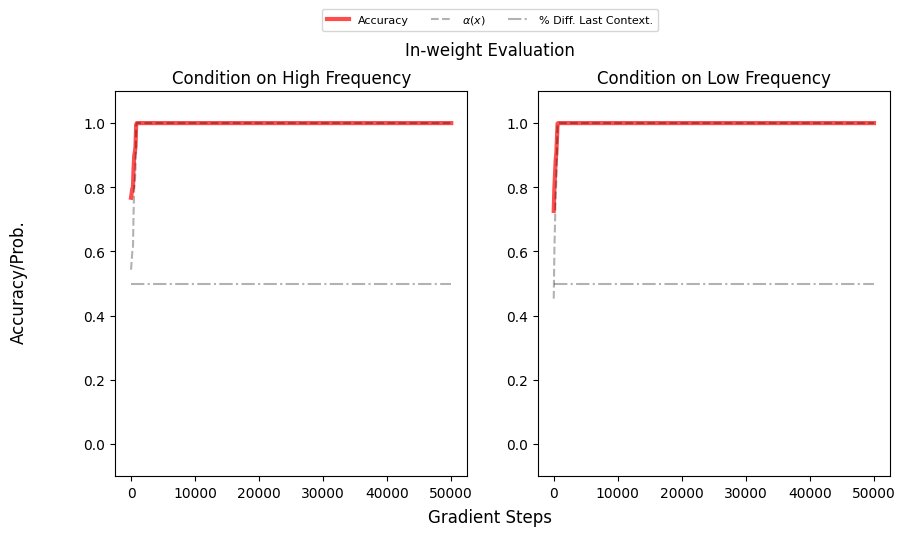

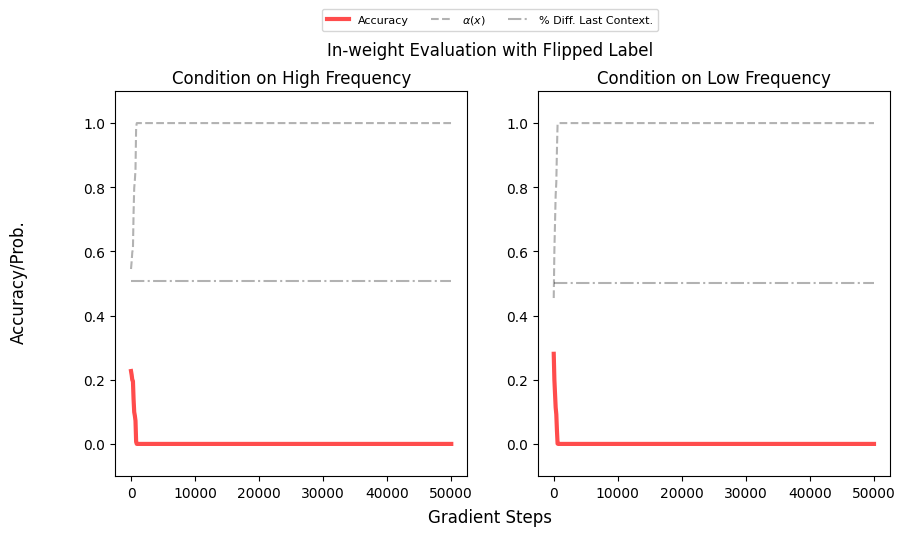

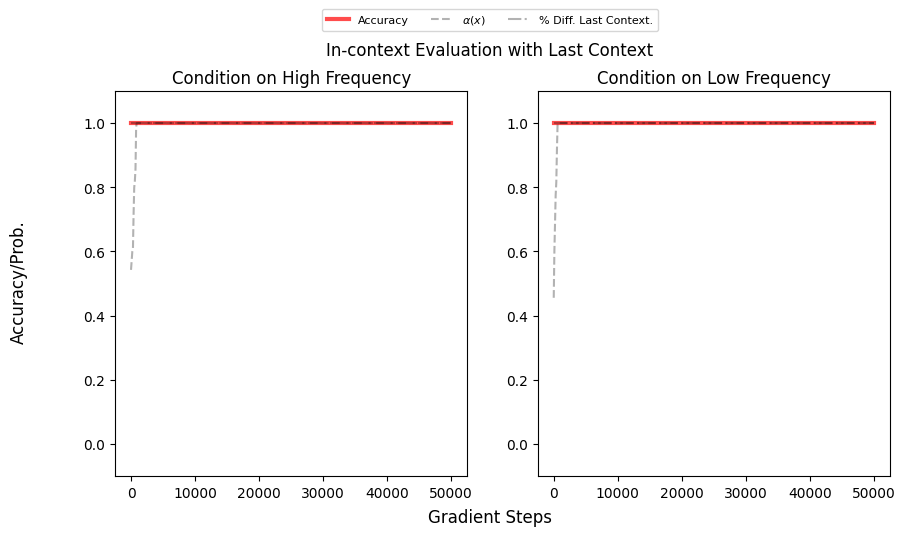

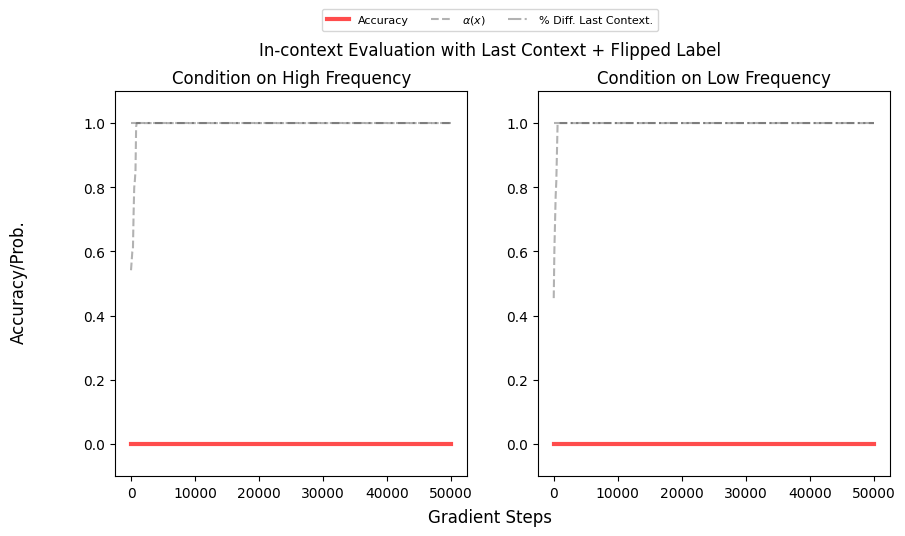

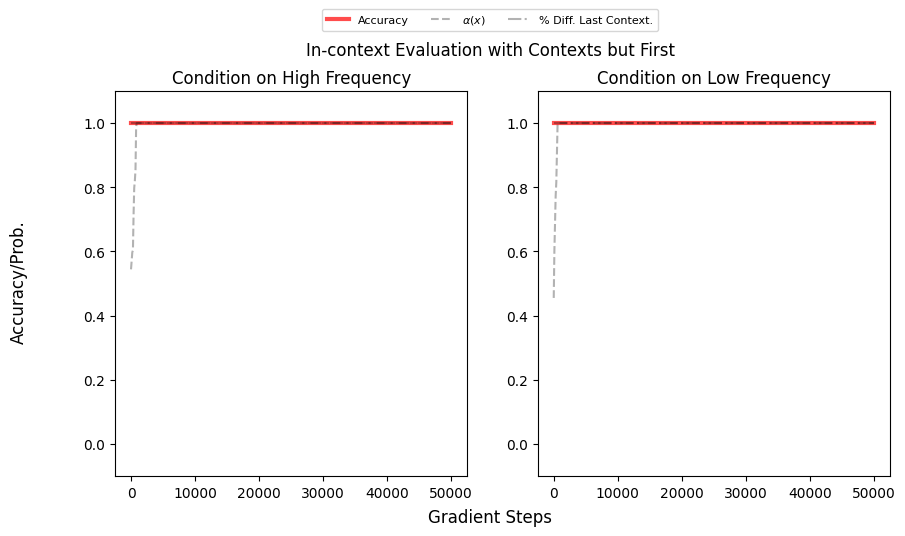

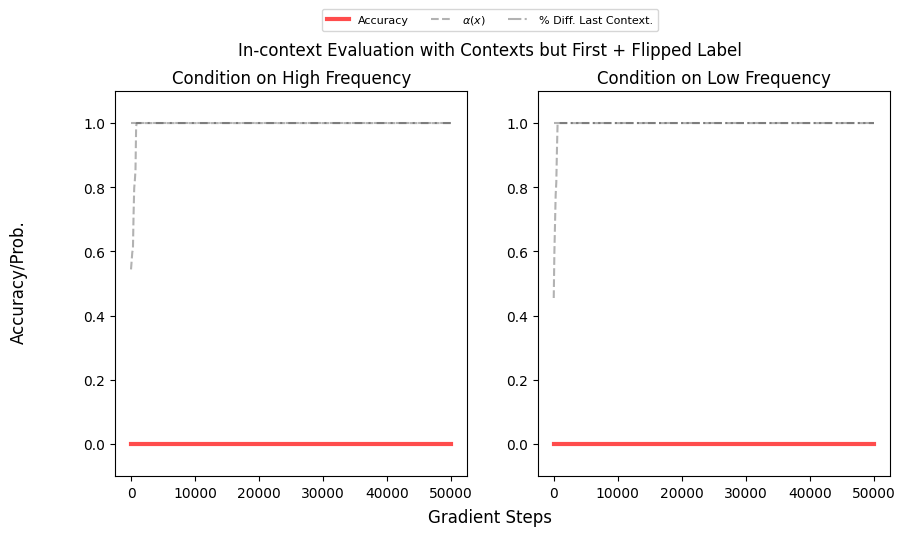

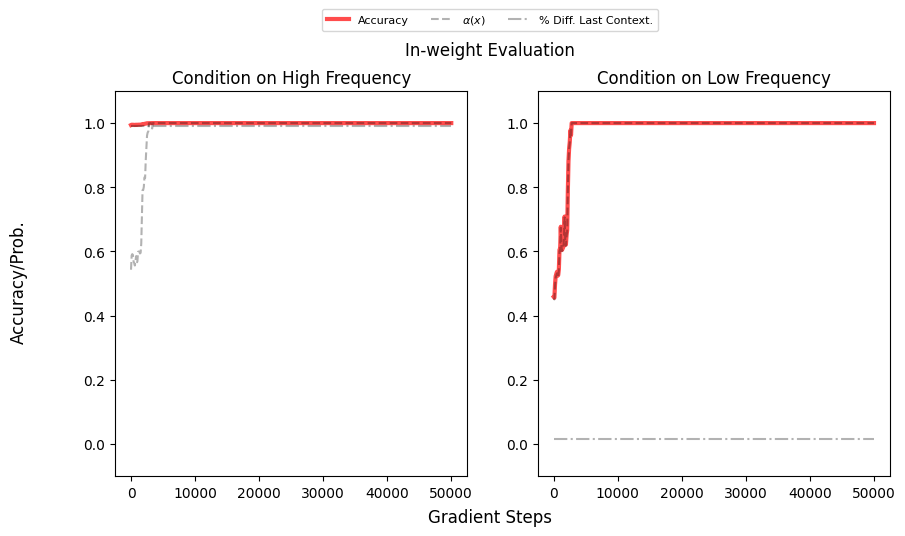

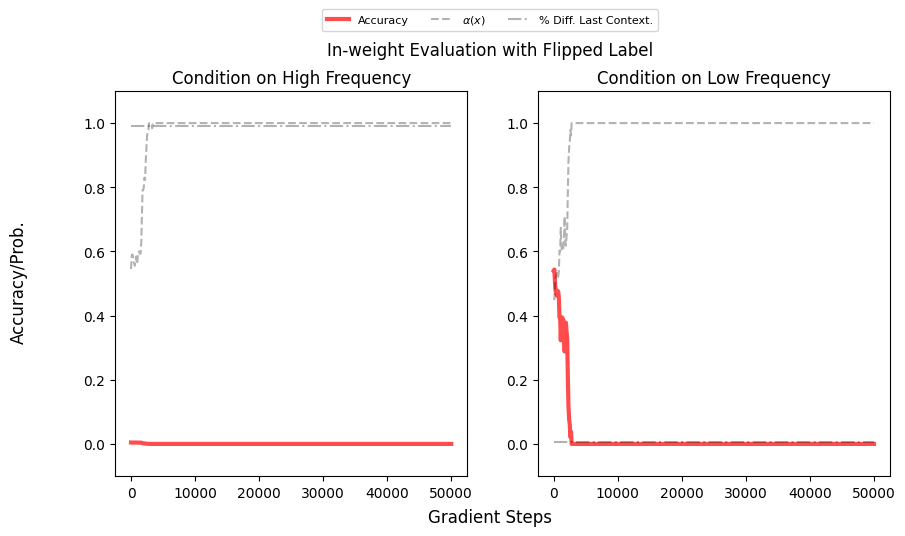

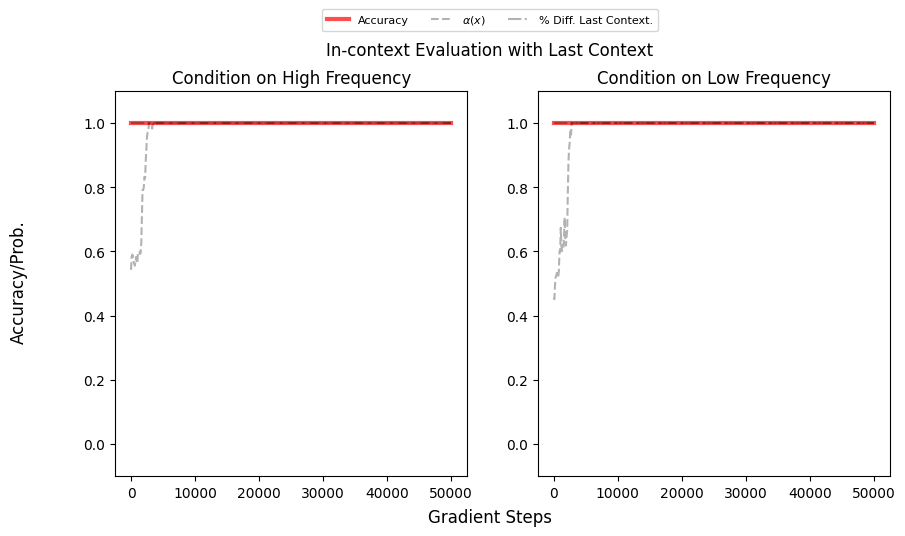

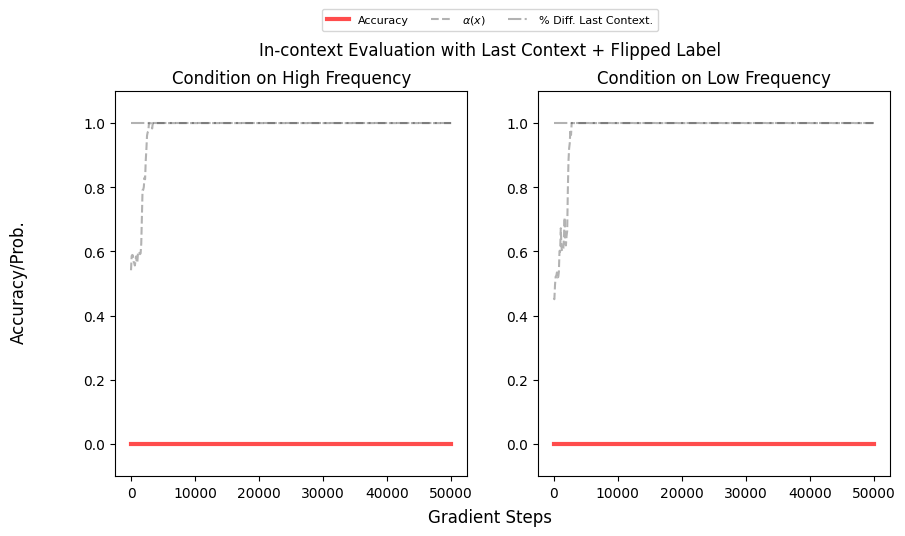

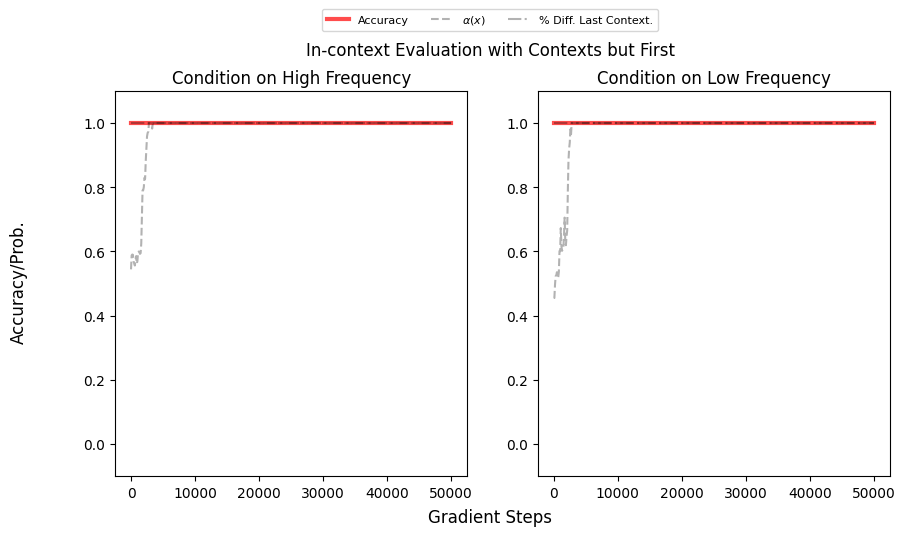

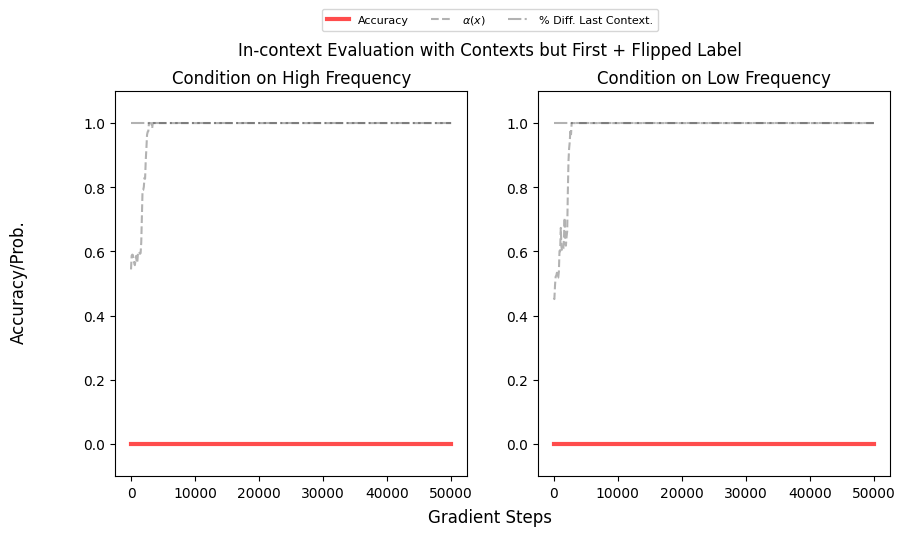

In [8]:
for prefix in prefixes:
    run_names = [os.path.join(results_dir, run_name) for run_name in os.listdir(results_dir) if run_name.startswith(prefix)]

    for eval_names, plot_name, plot_title in zip(eval_namess, plot_names, plot_titles):
        tic = timeit.default_timer()
        stats = dict()
        for run_i, run_name in enumerate(run_names):
            data = pickle.load(open(os.path.join(run_name, "evaluation.pkl"), "rb"))
            for eval_name in eval_names:
                stats.setdefault(eval_name, dict())
                for stats_key in stats_keys:
                    stats[eval_name].setdefault(stats_key, np.zeros((len(run_names), len(data["checkpoint_steps"]))))
                    stats[eval_name][stats_key][run_i] = data["stats"][eval_name][stats_key]

        agg_stats = dict()
        for eval_name in stats:
            agg_stats.setdefault(eval_name, dict())
            for stats_key in stats[eval_name]:
                agg_stats[eval_name][stats_key] = (
                    np.mean(stats[eval_name][stats_key], axis=0),
                    np.std(stats[eval_name][stats_key], axis=0),
                )

        fig, axes = plt.subplots(1, len(eval_names), figsize=(5 * len(eval_names), 5))

        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[eval_i]
            ax.plot(
                data["checkpoint_steps"],
                np.array(agg_stats[eval_name]["accuracy"][0]) / 100.0,
                label="Accuracy" if eval_i == 0 else "",
                linewidth=3,
                c="red",
                alpha=0.7,
            )
            ax.plot(
                data["checkpoint_steps"],
                agg_stats[eval_name]["p_iwl"][0],
                label="$\\alpha(x)$" if eval_i == 0 else "",
                linestyle="--",
                c="black",
                alpha=0.3
            )
            ax.plot(
                data["checkpoint_steps"],
                np.array(agg_stats[eval_name]["diff last context"][0]),
                label="% Diff. Last Context." if eval_i == 0 else "",
                linestyle="-.",
                c="black",
                alpha=0.3
            )
            ax.set_ylim(-0.1, 1.1)
            ax.set_title(map_eval_name[eval_name])

        fig.supylabel("Accuracy/Prob.")
        fig.supxlabel("Gradient Steps")
        fig.suptitle(plot_title)
        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=5,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )

        plt.savefig(
            os.path.join("/home/chanb/src/simple_icl/cc_utils/plots", "{}-{}.png".format(prefix, plot_name)),
            format="png",
            bbox_inches="tight",
            dpi=600,
        )
        toc = timeit.default_timer()
        print("Done {} {} in {}s".format(prefix, eval_name, toc - tic))

In [9]:
# results_dir = "/home/chanb/scratch/simple_icl/results/simple_icl-default"
# prefixes = ["high_prob_0.5", "high_prob_0.99"]

results_dir = "/home/chanb/scratch/simple_icl/results/simple_icl-g-high_prob_0.5"
prefixes = ["ground_truth_prob_0.0", "ground_truth_prob_0.9"]

eval_namess = [
    [
        "pretrain-sample_high_prob_class_only-start_pos_0",
        "pretrain-sample_low_prob_class_only-start_pos_0",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_0-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_0-flip_label",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_1",
        "pretrain-sample_low_prob_class_only-start_pos_1",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_1-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_1-flip_label",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_7",
        "pretrain-sample_low_prob_class_only-start_pos_7",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_7-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_7-flip_label",
    ],
]
plot_names = [
    "iwl",
    "iwl-flip_label",
    "icl-last_context",
    "icl-last_context-flip_label",
    "icl-except_first_context",
    "icl-except_first_context-flip_label",
]
plot_titles = [
    "In-weight Evaluation",
    "In-weight Evaluation with Flipped Label",
    "In-context Evaluation with Last Context",
    "In-context Evaluation with Last Context + Flipped Label",
    "In-context Evaluation with Contexts but First",
    "In-context Evaluation with Contexts but First + Flipped Label",
]

Done ground_truth_prob_0.0 pretrain-sample_low_prob_class_only-start_pos_0 in 91.37211202597246s
Done ground_truth_prob_0.0 pretrain-sample_low_prob_class_only-start_pos_0-flip_label in 88.4152297769906s
Done ground_truth_prob_0.0 pretrain-sample_low_prob_class_only-start_pos_1 in 87.96142400801182s
Done ground_truth_prob_0.0 pretrain-sample_low_prob_class_only-start_pos_1-flip_label in 87.76932901400141s
Done ground_truth_prob_0.0 pretrain-sample_low_prob_class_only-start_pos_7 in 87.80430571292527s
Done ground_truth_prob_0.0 pretrain-sample_low_prob_class_only-start_pos_7-flip_label in 87.90336826897692s
Done ground_truth_prob_0.9 pretrain-sample_low_prob_class_only-start_pos_0 in 94.51271066896152s
Done ground_truth_prob_0.9 pretrain-sample_low_prob_class_only-start_pos_0-flip_label in 87.23926086595748s
Done ground_truth_prob_0.9 pretrain-sample_low_prob_class_only-start_pos_1 in 87.33403448399622s
Done ground_truth_prob_0.9 pretrain-sample_low_prob_class_only-start_pos_1-flip_labe

KeyboardInterrupt: 

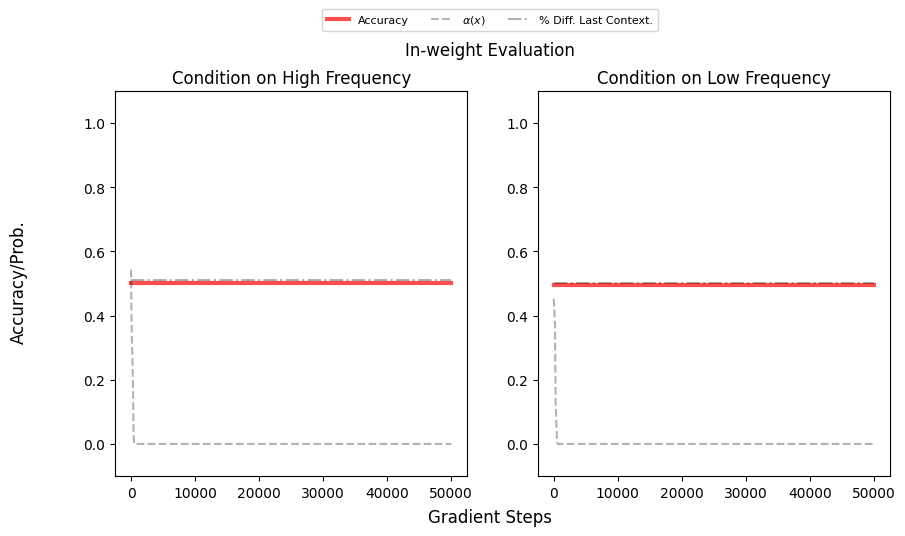

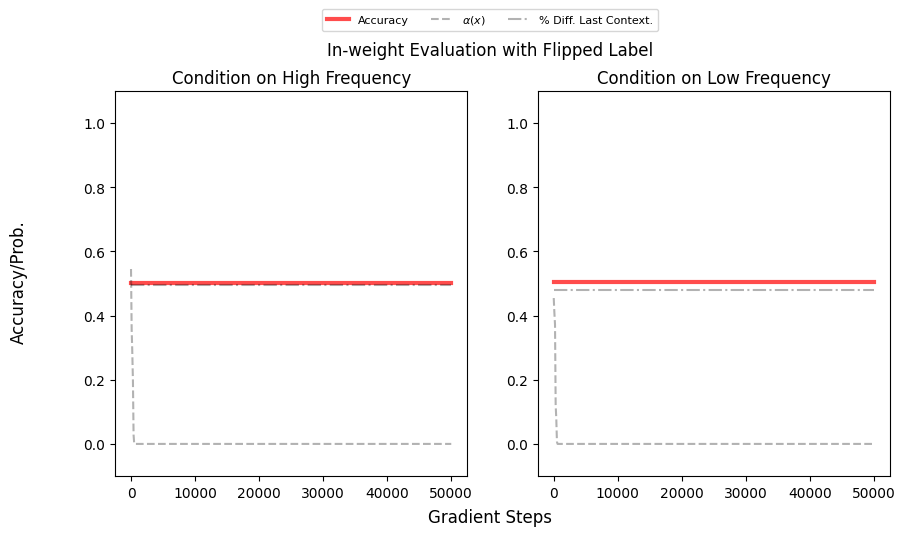

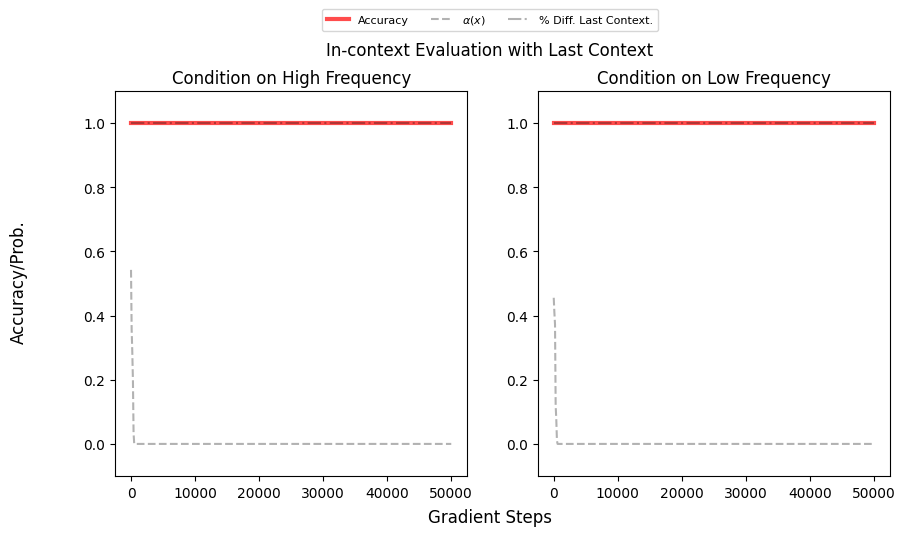

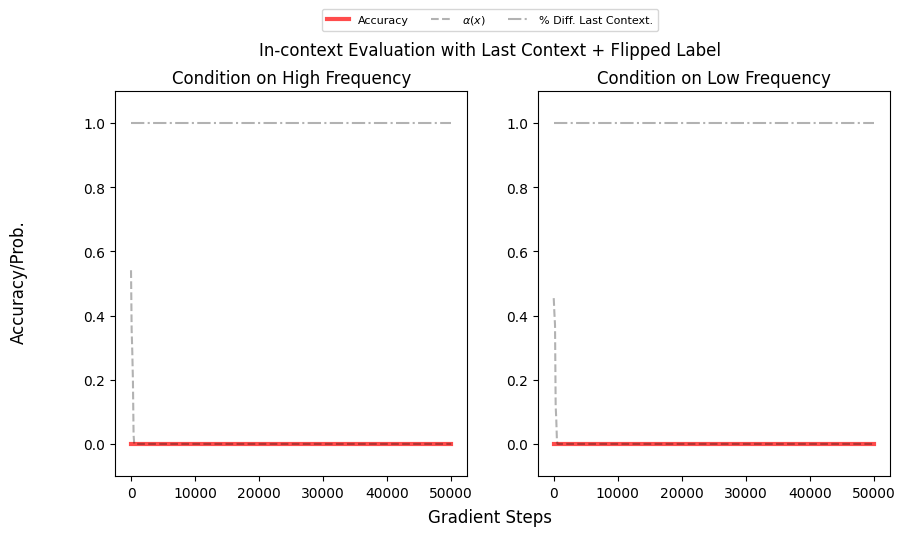

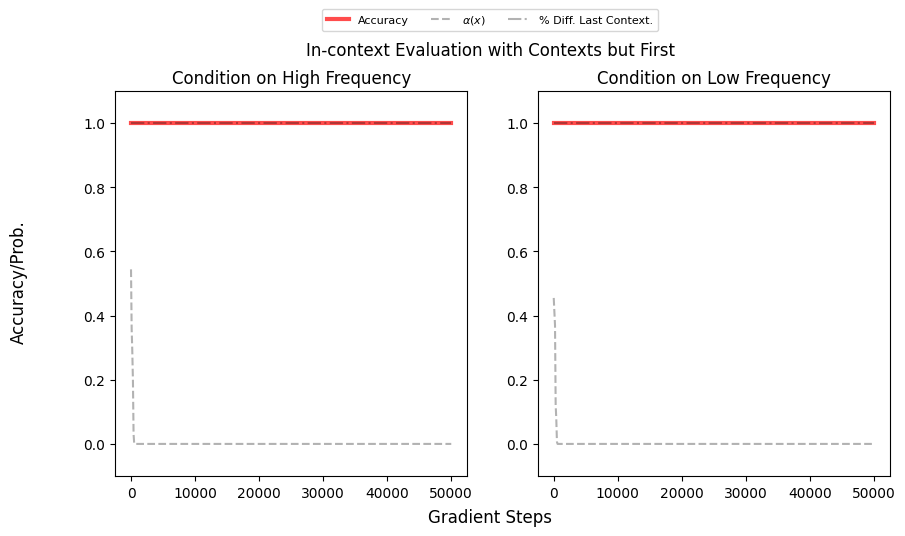

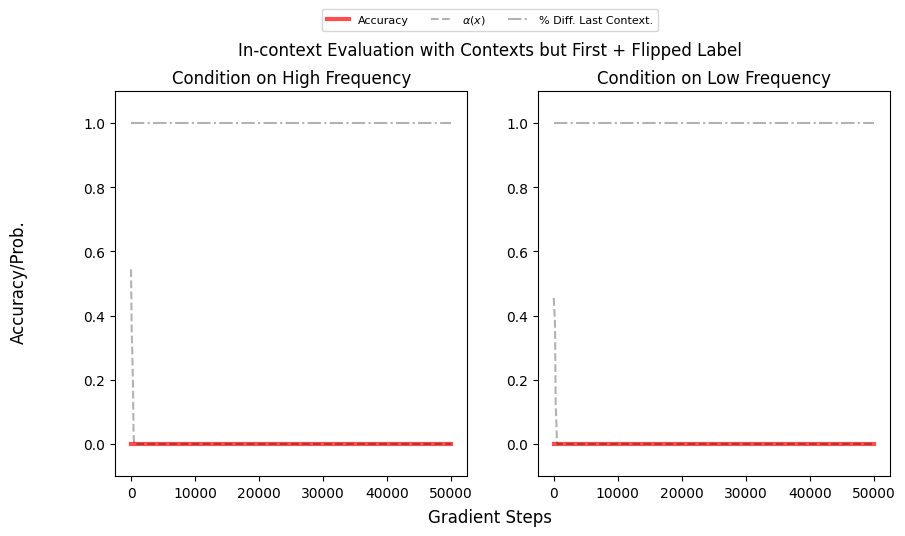

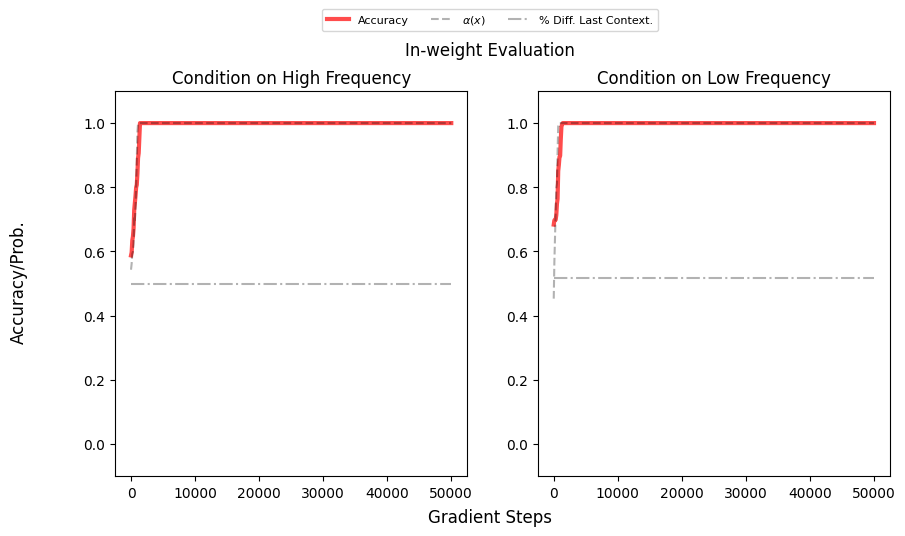

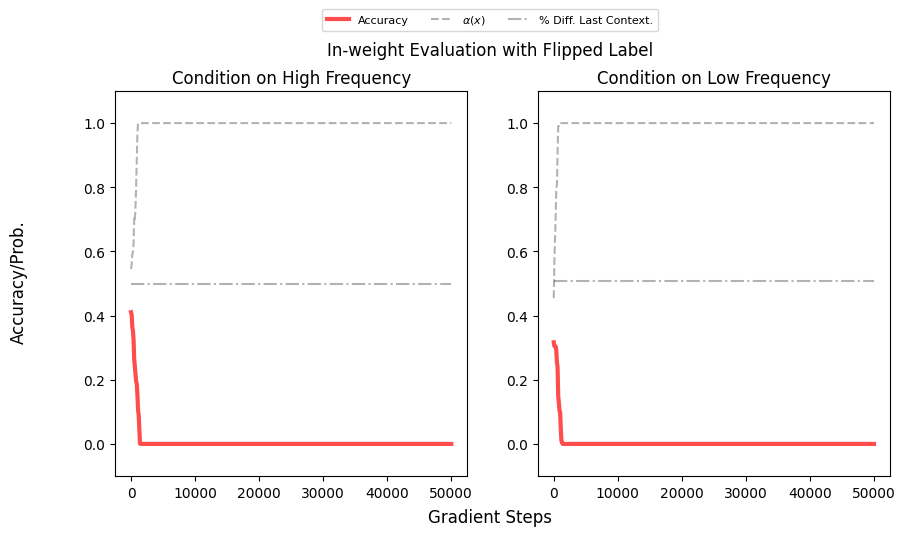

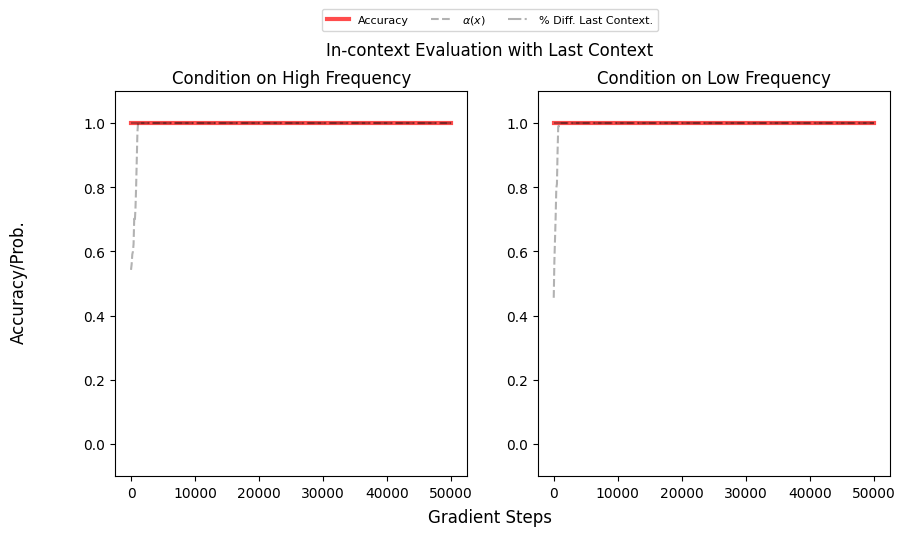

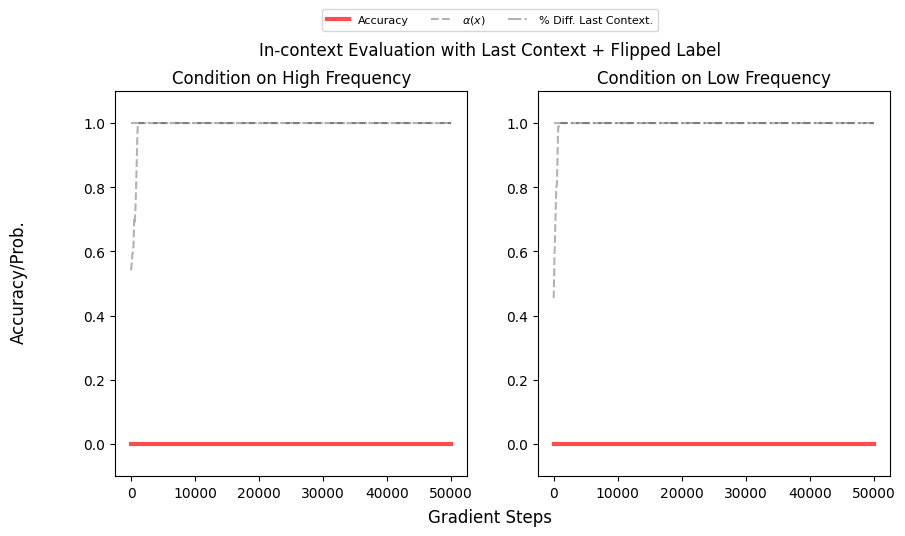

In [10]:
for prefix in prefixes:
    run_names = [os.path.join(results_dir, run_name) for run_name in os.listdir(results_dir) if run_name.startswith(prefix)]

    for eval_names, plot_name, plot_title in zip(eval_namess, plot_names, plot_titles):
        tic = timeit.default_timer()
        stats = dict()
        for run_i, run_name in enumerate(run_names):
            data = pickle.load(open(os.path.join(run_name, "evaluation.pkl"), "rb"))
            for eval_name in eval_names:
                stats.setdefault(eval_name, dict())
                for stats_key in stats_keys:
                    stats[eval_name].setdefault(stats_key, np.zeros((len(run_names), len(data["checkpoint_steps"]))))
                    stats[eval_name][stats_key][run_i] = data["stats"][eval_name][stats_key]

        agg_stats = dict()
        for eval_name in stats:
            agg_stats.setdefault(eval_name, dict())
            for stats_key in stats[eval_name]:
                agg_stats[eval_name][stats_key] = (
                    np.mean(stats[eval_name][stats_key], axis=0),
                    np.std(stats[eval_name][stats_key], axis=0),
                )

        fig, axes = plt.subplots(1, len(eval_names), figsize=(5 * len(eval_names), 5))

        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[eval_i]
            ax.plot(
                data["checkpoint_steps"],
                np.array(agg_stats[eval_name]["accuracy"][0]) / 100.0,
                label="Accuracy" if eval_i == 0 else "",
                linewidth=3,
                c="red",
                alpha=0.7,
            )
            ax.plot(
                data["checkpoint_steps"],
                agg_stats[eval_name]["p_iwl"][0],
                label="$\\alpha(x)$" if eval_i == 0 else "",
                linestyle="--",
                c="black",
                alpha=0.3
            )
            ax.plot(
                data["checkpoint_steps"],
                data["stats"][eval_name]["diff last context"],
                label="% Diff. Last Context." if eval_i == 0 else "",
                linestyle="-.",
                c="black",
                alpha=0.3
            )
            ax.set_ylim(-0.1, 1.1)
            ax.set_title(map_eval_name[eval_name])

        fig.supylabel("Accuracy/Prob.")
        fig.supxlabel("Gradient Steps")
        fig.suptitle(plot_title)
        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=5,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )

        plt.savefig(
            os.path.join("/home/chanb/src/simple_icl/cc_utils/plots", "{}-{}.png".format(prefix, plot_name)),
            format="png",
            bbox_inches="tight",
            dpi=600,
        )
        toc = timeit.default_timer()
        print("Done {} {} in {}s".format(prefix, eval_name, toc - tic))

In [11]:
# TODO: Check P(g(x) = 0) = 0 with ICL flip label, see if we get 50/50
prefix = "ground_truth_prob_0.0"
eval_names = [
    "pretrain-sample_high_prob_class_only-start_pos_1-flip_label",
    "pretrain-sample_low_prob_class_only-start_pos_1-flip_label",
]

In [12]:
run_names = [os.path.join(results_dir, run_name) for run_name in os.listdir(results_dir) if run_name.startswith(prefix)]

In [19]:
data["stats"][eval_name].keys()

dict_keys(['accuracy', 'loss', 'similarity', 'ic_pred', 'iw_pred', 'p_iwl', 'p_iwl given diff last context', 'diff last context'])

In [23]:
import jax

In [28]:
eval_name

'pretrain-sample_low_prob_class_only-start_pos_1-flip_label'

In [26]:
jax.nn.softmax(data["stats"][eval_name]["similarity"][0] / 0.1)

Array([3.3356553e-09, 3.3284548e-09, 3.3369090e-09, 3.3401630e-09,
       3.3434391e-09, 3.3287786e-09, 3.3363363e-09, 1.0000000e+00],      dtype=float32)

In [31]:
len(data["stats"][eval_name]["ic_pred"])

501

In [29]:
data["stats"][eval_name]["ic_pred"][0], data["stats"][eval_name]["iw_pred"][0], data["stats"][eval_name]["p_iwl"][0]

(Array(0., dtype=float32), Array(1., dtype=float32), 0.0)

In [13]:
stats = dict()
for run_i, run_name in enumerate(run_names):
    data = pickle.load(open(os.path.join(run_name, "evaluation.pkl"), "rb"))
    for eval_name in eval_names:
        stats.setdefault(eval_name, dict())
        for stats_key in stats_keys:
            stats[eval_name].setdefault(stats_key, np.zeros((len(run_names), len(data["checkpoint_steps"]))))
            stats[eval_name][stats_key][run_i] = data["stats"][eval_name][stats_key]

agg_stats = dict()
for eval_name in stats:
    agg_stats.setdefault(eval_name, dict())
    for stats_key in stats[eval_name]:
        agg_stats[eval_name][stats_key] = (
            np.mean(stats[eval_name][stats_key], axis=0),
            np.std(stats[eval_name][stats_key], axis=0),
        )

Exception ignored in: <function tqdm.__del__ at 0x149cc6990dc0>
Traceback (most recent call last):
  File "/home/chanb/simple_icl/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/chanb/simple_icl/lib/python3.10/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [15]:
agg_stats

{'pretrain-sample_high_prob_class_only-start_pos_1-flip_label': {'accuracy': (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
fig, axes = plt.subplots(1, len(eval_names), figsize=(5 * len(eval_names), 5))

for eval_i, eval_name in enumerate(eval_names):
    ax = axes[eval_i]
    ax.plot(
        data["checkpoint_steps"],
        np.array(agg_stats[eval_name]["accuracy"][0]) / 100.0,
        label="Accuracy" if eval_i == 0 else "",
        linewidth=3,
        c="red",
        alpha=0.7,
    )
    ax.plot(
        data["checkpoint_steps"],
        agg_stats[eval_name]["p_iwl"][0],
        label="$\\alpha(x)$" if eval_i == 0 else "",
        linestyle="--",
        c="black",
        alpha=0.3
    )
    ax.plot(
        data["checkpoint_steps"],
        data["stats"][eval_name]["diff last context"],
        label="% Diff. Last Context." if eval_i == 0 else "",
        linestyle="-.",
        c="black",
        alpha=0.3
    )
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(map_eval_name[eval_name])

fig.supylabel("Accuracy/Prob.")
fig.supxlabel("Gradient Steps")
fig.suptitle(plot_title)
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=5,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8",
)
plt.show()